In [11]:
# IMPORT THƯ VIỆN CẦN THIẾT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import graphviz

In [12]:
# NẠP VÀ TIỀN XỬ LÝ DỮ LIỆU
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print("Kích thước dữ liệu:", df.shape)
print(df.head())

# Loại bỏ các cột không cần thiết
df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Điền giá trị thiếu
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Mã hóa dữ liệu phân loại
label_cols = ['Sex', 'Embarked']
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Tách dữ liệu X (features) và y (target)
X = df.drop('Survived', axis=1)
y = df['Survived']

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Kích thước dữ liệu: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            37345

/tmp/ipython-input-924466767.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-924466767.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [13]:
# XÂY DỰNG MÔ HÌNH CÂY QUYẾT ĐỊNH
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Dự đoán
y_pred_dt = dt.predict(X_test)

# Đánh giá
print("\n=== CÂY QUYẾT ĐỊNH ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


=== CÂY QUYẾT ĐỊNH ===
Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



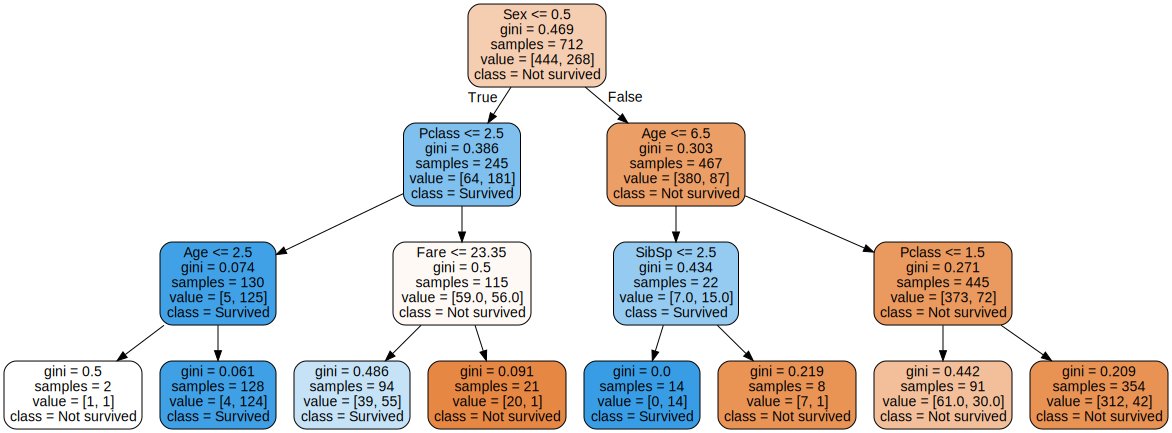

In [14]:
# Vẽ cây quyết định (Graphviz)
dot_data = export_graphviz(
    dt, out_file=None, filled=True, rounded=True,
    feature_names=X.columns, class_names=['Not survived', 'Survived']
)
graph = graphviz.Source(dot_data)
graph

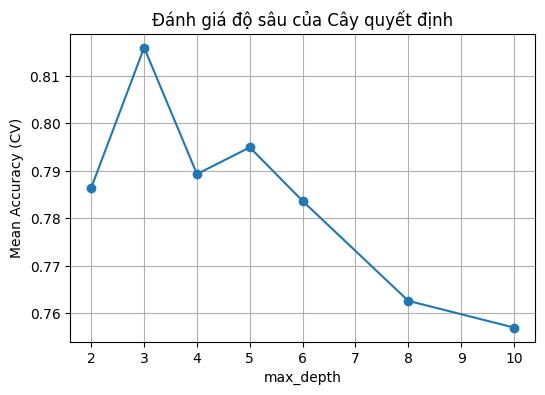

Best depth: {'max_depth': 3}


In [15]:
# GRID SEARCH — TÌM max_depth TỐI ƯU
params = {'max_depth': [2, 3, 4, 5, 6, 8, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=params,
                       scoring='accuracy', cv=5, return_train_score=True)
grid_dt.fit(X_train, y_train)

# Vẽ biểu đồ kết quả Grid Search
results = pd.DataFrame(grid_dt.cv_results_)
plt.figure(figsize=(6,4))
plt.plot(results['param_max_depth'], results['mean_test_score'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean Accuracy (CV)')
plt.title('Đánh giá độ sâu của Cây quyết định')
plt.grid(True)
plt.show()

print("Best depth:", grid_dt.best_params_)


=== RỪNG CÂY ===
Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



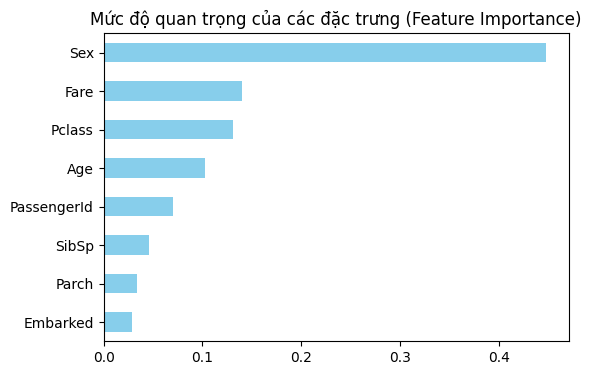

In [16]:
# XÂY DỰNG MÔ HÌNH RỪNG CÂY (RANDOM FOREST)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n=== RỪNG CÂY ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Vẽ biểu đồ mức độ quan trọng của từng feature
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(6,4))
feat_imp.plot(kind='barh', color='skyblue')
plt.title("Mức độ quan trọng của các đặc trưng (Feature Importance)")
plt.show()

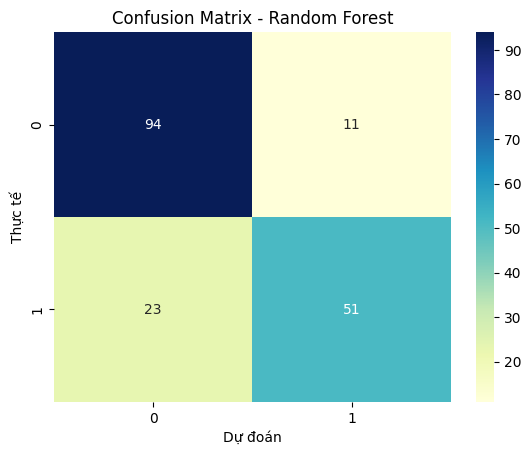

In [17]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()